# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

im_transform = transforms.RandomChoice([transforms.Grayscale(num_output_channels=3), 
                                        transforms.RandomHorizontalFlip(p=1.0),
                                        lambda x: x,
                                        transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]),
                                        transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
                                        transforms.Compose([transforms.Resize(640), transforms.CenterCrop(520)]),
                                        DefinedRotation(15), QuadrantCut()])

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=im_transform, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2,
                  momentum=0.9,
                  dampening=0,
                  weight_decay=0,
                  nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,
)

adam = torch.optim.Adam
adam_params = params = dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)

qhadam = optim.QHAdam
qhadam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)

radam = optim.RAdam
radam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)

yogi = optim.Yogi
yogi_params = dict(lr=1e-2,
                   betas=(0.9, 0.999),
                   eps=1e-3,
                   initial_accumulator=1e-6,
                   weight_decay=0)

In [4]:
batch_size=96
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([5, 7, 10, 17], gamma=0.1) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
augmentation_weights = {"None": 1.0}




# Single Models

## LXMERT

In [5]:
lr_strategy = {"lxmert": {"model":{"bert":{
    "embeddings": {"lr": optimizer_params["lr"]/1e3},
    "encoder": {"x_layers": {"lr": optimizer_params["lr"]/1e1}, "lr": optimizer_params["lr"]/1e2},
    "pooler": {"lr": optimizer_params["lr"]/1e1},
}}}}

In [6]:


from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel, 
                         dict(model_name=["lxmert"], num_classes=2,
                 gaussian_noise=0.25, dropout=0.25,
                              featurizer="transformer",final_layer_builder=fb_1d_loss_builder,
                 internal_dims=512, classifier_dims=256,
                 n_tokens_out=16, n_layers=2,task="classification", finetune=True),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.



Epoch =  1 Loss = 0.938109 LR = 0.00000003
Epoch =  1 Train = 0.611699 Val = 0.611455



Epoch =  2 Loss = 0.825486 LR = 0.00000007



Epoch =  3 Loss = 0.809208 LR = 0.00000010



Epoch =  4 Loss = 0.781734 LR = 0.00000010
Epoch =  4 Train = 0.625187 Val = 0.621212



Epoch =  5 Loss = 0.748761 LR = 0.00000008



Epoch =  6 Loss = 0.732344 LR = 0.00000006



Epoch =  7 Loss = 0.710253 LR = 0.00000004
Epoch =  7 Train = 0.651805 Val = 0.620267



Epoch =  8 Loss = 0.704624 LR = 0.00000002



Epoch =  9 Loss = 0.697825 LR = 0.00000000
Epoch =  9 Train = 0.669537 Val = 0.637542


Exception for:  keyboard | '' '' '' | ['word_cutout' 'sentence_shuffle' 'half_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  10 Loss = 0.694655 LR = 0.00000000

VilBertVisualBertModel(
  (lxmert): LXRTEncoder(
    (model): LXRTFeatureExtraction(
      (bert): LXRTModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768, padding_idx=0)
          (token_type_embeddings): Embedding(2, 768, padding_idx=0)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): LXRTEncoder(
          (visn_fc): VisualFeatEncoder(
            (visn_fc): Linear(in_features=2048, out_features=768, bias=True)
            (visn_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (box_fc): Linear(in_features=4, out_features=768, bias=True)
            (box_lay

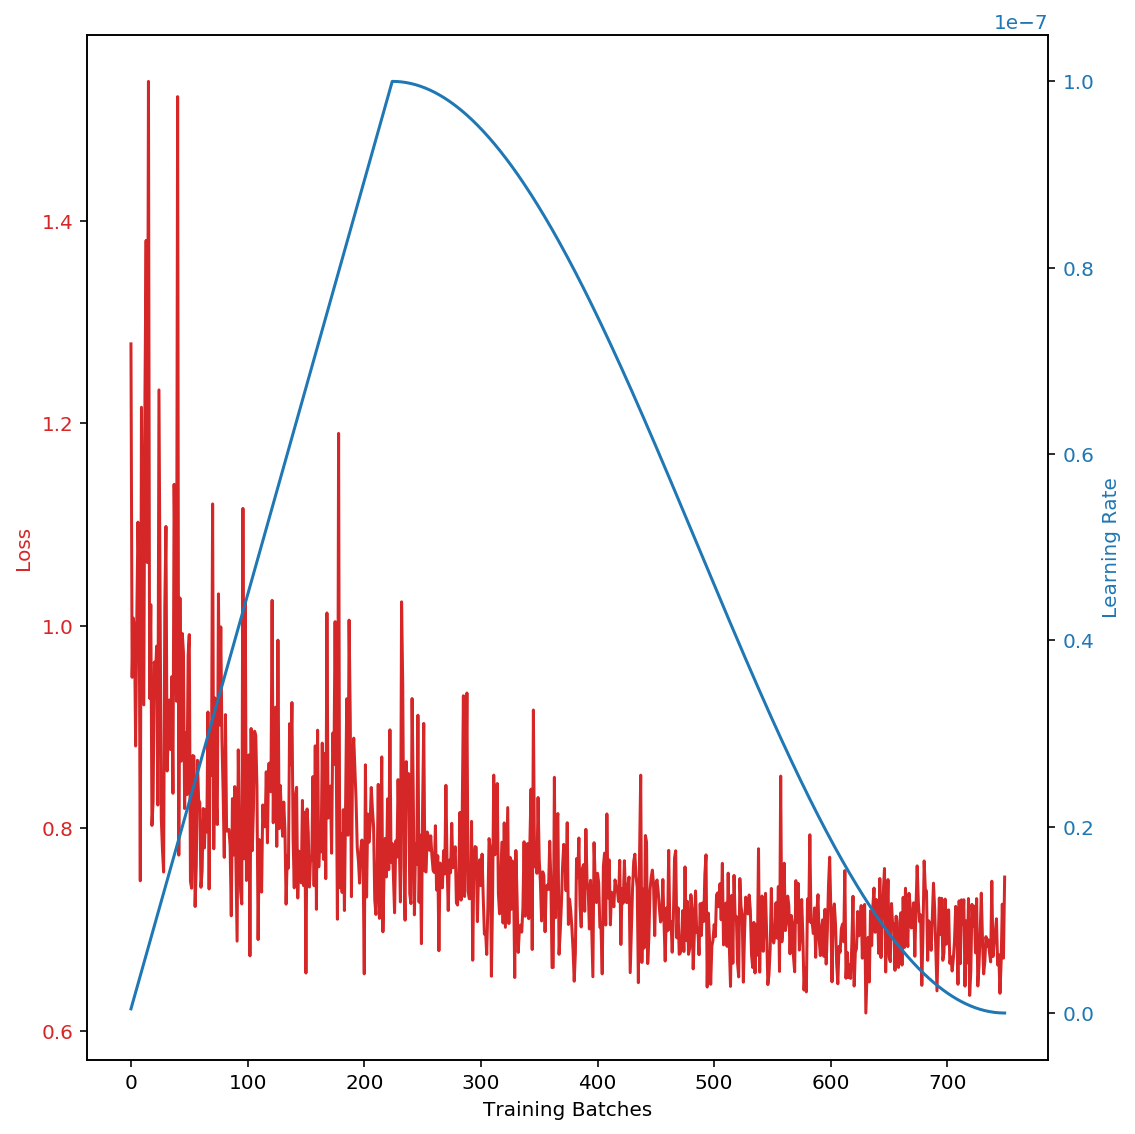

train   val
mean_or_std metric               
mean        map       0.539 0.482
            accuracy  0.644 0.623
            auc       0.672 0.638
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.721  0.715 0.718 4560.000     0.709  0.686 0.697 1140.000
pos     0.515  0.522 0.519 2640.000     0.486  0.514 0.500  660.000

In [7]:



multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs




## Visual BERT / VilBert

In [ ]:
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel,
                         dict(
                             model_name=["vilbert"],
                             num_classes=2,
                             gaussian_noise=0.25,
                             dropout=0.15,
                             featurizer="transformer",
                             final_layer_builder=fb_1d_loss_builder,
                             internal_dims=512,
                             classifier_dims=256,
                             n_tokens_out=16,
                             n_layers=2,
                             task="classification",
                             finetune_vilbert=False,
                             finetune_lxmert=False,
                             finetune_visual_bert=False,
                         ),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 1h 45m

# Triple Bert Pooled

In [5]:
batch_size = 24
epochs = 10
lr_strategy = {
    "lxmert": {
        "lr": optimizer_params["lr"] / 100
    },
    "vilbert": {
        "lr": optimizer_params["lr"] / 10000
    },
    "visual_bert": {
        "lr": optimizer_params["lr"] / 10000
    },
}

lr_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "embeddings": {
                    "lr": optimizer_params["lr"] / 1e3
                },
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"] / 1e2
                    },
                    "lr": optimizer_params["lr"] / 1e3
                },
                "pooler": {
                    "lr": optimizer_params["lr"] / 1e1
                },
            }
        },
        "lr": optimizer_params["lr"] / 100
    },
    "vilbert": {
        "lr": optimizer_params["lr"] / 10000,
        "model": {
            "bert": {
                "t_pooler": {
                    "lr": optimizer_params["lr"] / 1e2
                },
                "v_pooler": {
                    "lr": optimizer_params["lr"] / 1e2
                }
            }
        },
    },
    "visual_bert": {
        "model": {
            "bert": {
                "pooler": {
                    "lr": optimizer_params["lr"] / 1e2
                }
            }
        },
        "lr": optimizer_params["lr"] / 10000
    },
}


from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel,
                         dict(
                             model_name=["vilbert", "lxmert", "visual_bert"],
                             num_classes=2,
                             gaussian_noise=0.1,
                             dropout=0.35,
                             featurizer="pass",
                             final_layer_builder=fb_1d_loss_builder,
                             internal_dims=None,
                             classifier_dims=768,
                             n_tokens_out=64 + 100 + 64 + 36 + 64 + 100,
                             n_layers=2,
                             task="classification",
                             finetune_vilbert=False,
                             finetune_lxmert=True,
                             finetune_visual_bert=False,
                         ),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# 1h 45m

In [6]:

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19], 
    show_model_stats=True)
r1, p1 = results, prfs
results
prfs


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true
Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_h

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Trainable Params = 583607558 
 VilBertVisualBertModel(
  (vilbert): ViLBERT(
    (model): ViLBERTForClassification(
      (bert): ViLBERTBase(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (v_embeddings): BertImageFeatureEmbeddings(
          (image_embeddings): Linear(in_features=2048, out_features=1024, bias=True)
          (image_location_embeddings): Linear(in_features=5, out_features=1024, bias=True)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
         

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.75 GiB total capacity; 14.56 GiB already allocated; 8.88 MiB free; 14.58 GiB reserved in total by PyTorch)

# Triple Bert Transformer

In [ ]:
batch_size=32
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel

model_fn = model_builder(VilBertVisualBertModel, 
                         dict(model_name=["vilbert", "lxmert", "visual_bert"], num_classes=2,
                 gaussian_noise=0.25, dropout=0.15,
                              featurizer="transformer",final_layer_builder=fb_1d_loss_builder,
                 internal_dims=256, classifier_dims=256,
                 n_tokens_out=32, n_layers=2,task="classification", finetune=True),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)




n_tests = 1
multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs


# 1h 45m



# Predict

In [6]:
batch_size=16
epochs = 5

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, augmentation_weights, scheduler_init_fn=scheduler_init_fn)
submission.to_csv("submission.csv",index=False)
submission.sample(3)


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true
Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true
LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_h

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.



Epoch =  1 Loss = 0.523777 LR = 0.00066706



Epoch =  2 Loss = 0.417936 LR = 0.00095034



Epoch =  3 Loss = 0.412340 LR = 0.00061104



Epoch =  4 Loss = 0.374947 LR = 0.00018817


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
submission.head()

,id,proba,label
0,16395,0.553,1
1,37405,0.634,1
2,94180,0.658,1
3,54321,0.347,0
4,97015,0.720,1
